Сначала сделаю классификацию, потом регрессию

# Классификация

## Бейзлайн градиентного бустинга классификации

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("adult.csv")  

# Признаки и целевая переменная
X = data.drop('salary', axis=1)
y = data['salary'].apply(lambda x: 1 if x.strip() == '>50K' else 0)




In [2]:
# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Определяем категориальные и числовые признаки
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
# Препроцессор
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

# Пайплайн с GradientBoosting
gb_clf = Pipeline([
    ('prep', preprocessor),
    ('clf', GradientBoostingClassifier(random_state=42))
])

# Обучение модели
gb_clf.fit(X_train, y_train)

# Предсказания
y_pred = gb_clf.predict(X_test)
y_pred_proba = gb_clf.predict_proba(X_test)[:, 1]

In [4]:




# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Сохраняем результаты в формате для дальнейшей работы
results_gb_clf = []
results_gb_clf.append({
    "Гипотеза": "Gradient Boosting базовый",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

In [5]:
print("Результаты базовой модели:\n")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC_AUC: {roc_auc:.4f}")

Результаты базовой модели:

Accuracy: 0.8690
F1-score: 0.6963
ROC_AUC: 0.9238


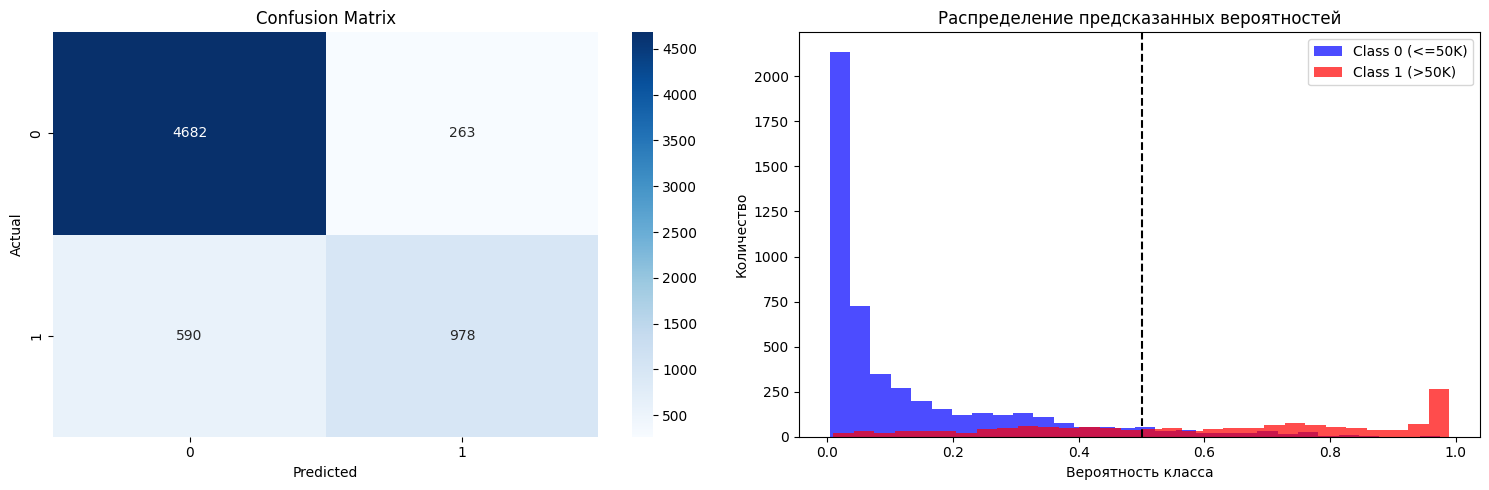

In [6]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок и распределения вероятностей
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Распределение предсказанных вероятностей
axes[1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='Class 0 (<=50K)', color='blue')
axes[1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Class 1 (>50K)', color='red')
axes[1].set_title('Распределение предсказанных вероятностей')
axes[1].set_xlabel('Вероятность класса')
axes[1].set_ylabel('Количество')
axes[1].legend()
axes[1].axvline(x=0.5, color='black', linestyle='--')

plt.tight_layout()
plt.show()

Результаты бейзлайна градиент бустинга уже показывают наилучшие результаты, которые я только видел. Точность 0,87 при таком F1 score я не видел, если не ошиибась ни за одну лабораторную. Так же по графику распределения предсказанных вероятностей можно сразу понять что мы будем двигать порог определения классов влево. И скорее всего за счет егого мы получим небольшие улучшения F1 score. 

# Выдвигаем гипотезы:

## Гипотеза 1: cдвиг порога классификации

## Гипотеза 2: подбор гиперпараметров

## Гипотеза 3: Feature importance + удаление слабых признаков

In [7]:
# Гипотеза 1
# Берём вероятности от базового градиентного бустинга
y_pred_proba = gb_clf.predict_proba(X_test)[:, 1]

# Проверяем пороги от 0.1 до 0.9
thresholds = np.arange(0.1, 0.91, 0.01)
best_f1 = 0
best_threshold = 0.5

for t in thresholds:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# Считаем метрики при лучшем пороге
y_pred_best = (y_pred_proba >= best_threshold).astype(int)
acc = accuracy_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Сохраняем результаты
results_gb_clf.append({
    "Гипотеза": f"Сдвиг порога (порог={best_threshold:.2f})",
    "Accuracy": acc,
    "F1": best_f1,
    "ROC_AUC": roc_auc
})

# Вывод лучшего порога
print(f"Лучший порог: {best_threshold:.2f}")

Лучший порог: 0.32


In [8]:
# Гипотеза 2

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Параметры для поиска
param_dist = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.7, 0.8, 1.0],
    "clf__min_samples_split": [2, 5, 10]
}

# Пробуем два варианта: с балансировкой классов и без
class_weights = [None, "balanced"]

best_score = 0
best_params = None
best_model = None

for cw in class_weights:
    gb = Pipeline([
        ('prep', preprocessor),
        ('clf', GradientBoostingClassifier(random_state=42))
    ])
    
    if cw is not None:
        sample_weight = y_train.map({0:1, 1:sum(y_train==0)/sum(y_train==1)}) if cw=='balanced' else None
    else:
        sample_weight = None

    rnd_search = RandomizedSearchCV(
        gb, param_distributions=param_dist, n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=42
    )
    rnd_search.fit(X_train, y_train, clf__sample_weight=sample_weight)
    
    if rnd_search.best_score_ > best_score:
        best_score = rnd_search.best_score_
        best_params = rnd_search.best_params_
        best_model = rnd_search.best_estimator_

# Предсказания и метрики
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Сохраняем результаты
results_gb_clf.append({
    "Гипотеза": "Подбор гиперпараметров + баланс классов",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

print("Лучшие гиперпараметры:")
print(best_params)


Лучшие гиперпараметры:
{'clf__subsample': 1.0, 'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}


In [9]:
# Гипотеза 3

importances = gb_clf.named_steps['clf'].feature_importances_

ohe = gb_clf.named_steps['prep'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_features).tolist()
feature_names = cat_names + num_features

X_train_transformed = gb_clf.named_steps['prep'].transform(X_train)
if hasattr(X_train_transformed, "toarray"):  # если sparse
    X_train_transformed = X_train_transformed.toarray()
X_test_transformed = gb_clf.named_steps['prep'].transform(X_test)
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

feat_df = pd.DataFrame({"feature": feature_names, "importance": importances})
important_feats = feat_df[feat_df['importance'] > 0.04]['feature'].tolist()

X_train_imp = X_train_df[important_feats]
X_test_imp = X_test_df[important_feats]

# Обучаем модель на важных признаках
gb_imp = GradientBoostingClassifier(random_state=42)
gb_imp.fit(X_train_imp, y_train)

# Предсказания
y_pred = gb_imp.predict(X_test_imp)
y_pred_proba = gb_imp.predict_proba(X_test_imp)[:,1]

# Метрики
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Сохраняем результаты
results_gb_clf.append({
    "Гипотеза": "Удаление слабых признаков (<4%)",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})


In [10]:
df_results = pd.DataFrame(results_gb_clf)

# Округляем метрики для наглядности
df_results[['Accuracy', 'F1', 'ROC_AUC']] = df_results[['Accuracy', 'F1', 'ROC_AUC']].round(4)

print("="*70)
print("Сравнение всех моделей Gradient Boosting ")
print("="*70)

# Сортировка
display(df_results.sort_values("F1", ascending=False))

Сравнение всех моделей Gradient Boosting 


,Гипотеза,Accuracy,F1,ROC_AUC
2,Подбор гиперпараметров + баланс классов,0.8437,0.7285,0.9314
1,Сдвиг порога (порог=0.32),0.8554,0.7281,0.9238
0,Gradient Boosting базовый,0.8690,0.6963,0.9238
3,Удаление слабых признаков (<4%),0.8644,0.6883,0.9136


Ну по сути мы видим либо отстутсвие улучшения в случае с гипотезой 3. Даже небольшие ухудшение. В зависимости от процента удаления слабых признаков. Я потестировал разные значения. Ну лучшие результаты получается при 4-5 процентах. Так что решил оставить 4. А в случае со сдвигом порога и подбором гиперпараметров + баланс классов мы видимо по сути просто переливание из точности в F1. Хотя сдвиг порога дает очень неплохие результаты, мы получаем в F1 гораздо больше чем теряем в точности по сравнению с базовой моделью. Ну попробую совместить сдвиг порога и подбор гиперпараметров в одну модель. Ето и будет наш улучшенный бейзлайн.

# Улучшенный бейзлайн градиентного бустинга классификации

Гиперпараметры лучшие возьмем из предыдущей модели, а порог лучший порог будем искать заново т.к. он может сдвинуться.

In [11]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix


# гиперпараметры
best_params = {
    'subsample': 1.0,
    'n_estimators': 300,
    'min_samples_split': 10,
    'max_depth': 5,
    'learning_rate': 0.1
}

gb_best = Pipeline([
    ('prep', preprocessor),
    ('clf', GradientBoostingClassifier(random_state=42, **best_params))
])




In [12]:
# Обучаем модель
gb_best.fit(X_train, y_train)

# Предсказанные вероятности
y_pred_proba = gb_best.predict_proba(X_test)[:, 1]

# Поиск оптимального порога для F1-score
thresholds = np.arange(0.1, 0.91, 0.01)
best_f1 = 0
best_threshold = 0.5

for t in thresholds:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    f1_score_val = f1_score(y_test, y_pred_thresh)
    if f1_score_val > best_f1:
        best_f1 = f1_score_val
        best_threshold = t

# Предсказания с оптимальным порогом
y_pred = (y_pred_proba >= best_threshold).astype(int)

In [13]:
# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Сохраняем результаты
results_gb_clf.append({
    "Гипотеза": f"Улучшенный бейзлайн (порог={best_threshold:.2f})",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

print("Результаты улучшенного бейзлайна:\n")
print(f"Лучший порог: {best_threshold:.2f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC_AUC: {roc_auc:.4f}")

Результаты улучшенного бейзлайна:

Лучший порог: 0.37
Accuracy: 0.8680
F1-score: 0.7413
ROC_AUC: 0.9309


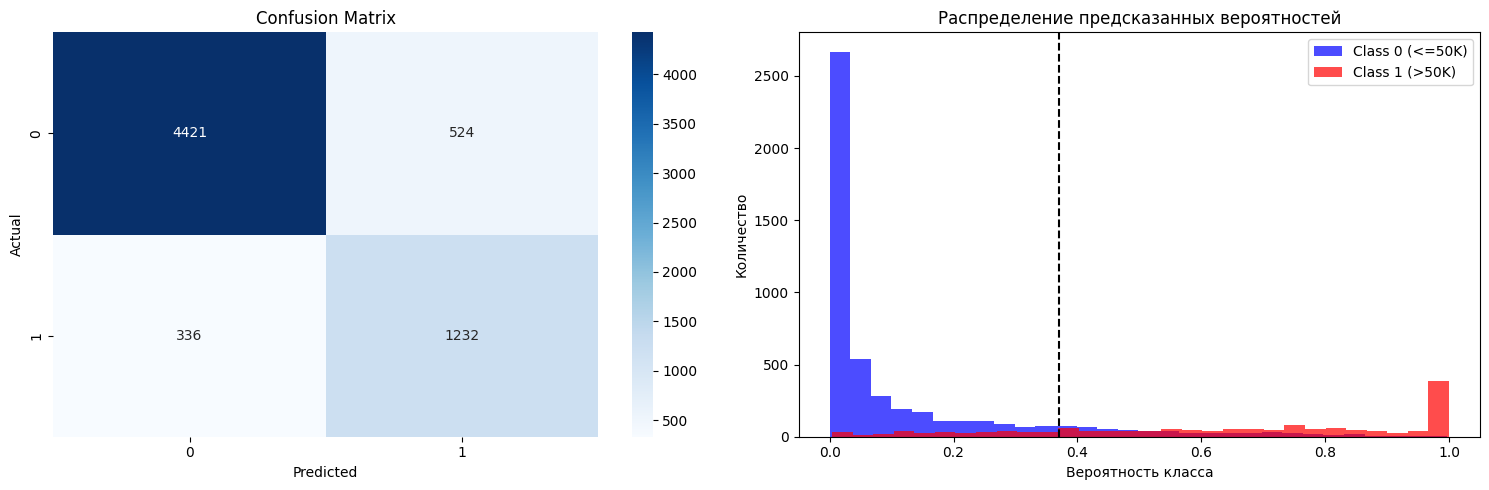

In [14]:




# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок и распределения вероятностей
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Распределение предсказанных вероятностей
axes[1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='Class 0 (<=50K)', color='blue')
axes[1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Class 1 (>50K)', color='red')
axes[1].set_title('Распределение предсказанных вероятностей')
axes[1].set_xlabel('Вероятность класса')
axes[1].set_ylabel('Количество')
axes[1].legend()
axes[1].axvline(x=best_threshold, color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [15]:
df_results = pd.DataFrame(results_gb_clf)

# Округляем метрики для наглядности
df_results[['Accuracy', 'F1', 'ROC_AUC']] = df_results[['Accuracy', 'F1', 'ROC_AUC']].round(4)

print("="*70)
print("Сравнение всех моделей Gradient Boosting ")
print("="*70)

# Сортировка
display(df_results.sort_values("F1", ascending=False))

Сравнение всех моделей Gradient Boosting 


,Гипотеза,Accuracy,F1,ROC_AUC
4,Улучшенный бейзлайн (порог=0.37),0.8680,0.7413,0.9309
2,Подбор гиперпараметров + баланс классов,0.8437,0.7285,0.9314
1,Сдвиг порога (порог=0.32),0.8554,0.7281,0.9238
0,Gradient Boosting базовый,0.8690,0.6963,0.9238
3,Удаление слабых признаков (<4%),0.8644,0.6883,0.9136


Как мы видим совмещение двух гипотез позволило нам серьезно улучшить показатель F1. При етом показатель точности не просел, хотя обычно улучшение F1 к етому приводило. По сравнению с базовым градиентным бустингом я смог выиграть 5% F1, при етом вообще не потерял в точности. И получил лучшие результаты классификации за все 5 лабораторных.

# Имплементация градиентного бустинга классификации

In [16]:
from sklearn.tree import DecisionTreeRegressor

# Собственный градиентный бустинг
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)


class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=25):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.F0 = None
        
    def fit(self, X, y):
        self.F0 = np.log((y.mean() + 1e-9) / (1 - y.mean() + 1e-9))
        F_pred = np.full(y.shape, self.F0)
        self.trees = []

        for _ in range(self.n_estimators):

            p = 1 / (1 + np.exp(-F_pred))  
            residual = y - p               

            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)
            self.trees.append(tree)

            # Обновляем предсказания
            F_pred += self.learning_rate * tree.predict(X)
    
    def predict_proba(self, X):
        F_pred = np.full(X.shape[0], self.F0)
        for tree in self.trees:
            F_pred += self.learning_rate * tree.predict(X)
        return 1 / (1 + np.exp(-F_pred))
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


# Обучение

my_gb = MyGradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=25)
my_gb.fit(X_train_proc, y_train)

y_pred_proba = my_gb.predict_proba(X_test_proc)
y_pred = my_gb.predict(X_test_proc)

# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Бейзлайн с собственным градиентным бустингом:\n")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC_AUC: {roc_auc:.4f}")



Бейзлайн с собственным градиентным бустингом:

Accuracy: 0.8316
F1-score: 0.6290
ROC_AUC: 0.8725


In [17]:

results_gb_clf.append({
    "Гипотеза": "Имплементированный градиентный бустинг",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

In [18]:
df_results = pd.DataFrame(results_gb_clf)

# Округляем метрики для наглядности
df_results[['Accuracy', 'F1', 'ROC_AUC']] = df_results[['Accuracy', 'F1', 'ROC_AUC']].round(4)

print("="*70)
print("Сравнение всех моделей Gradient Boosting ")
print("="*70)

# Сортировка
display(df_results.sort_values("F1", ascending=False))

Сравнение всех моделей Gradient Boosting 


,Гипотеза,Accuracy,F1,ROC_AUC
4,Улучшенный бейзлайн (порог=0.37),0.8680,0.7413,0.9309
2,Подбор гиперпараметров + баланс классов,0.8437,0.7285,0.9314
1,Сдвиг порога (порог=0.32),0.8554,0.7281,0.9238
0,Gradient Boosting базовый,0.8690,0.6963,0.9238
3,Удаление слабых признаков (<4%),0.8644,0.6883,0.9136
5,Имплементированный градиентный бустинг,0.8316,0.6290,0.8725


Как можно заметить мой собственный градиентный бустинг получился самым плохим. Сильно уступает по F1 другим моделям. Попробуем ето исправить, совместив с ним гипотезы 1 и 2.

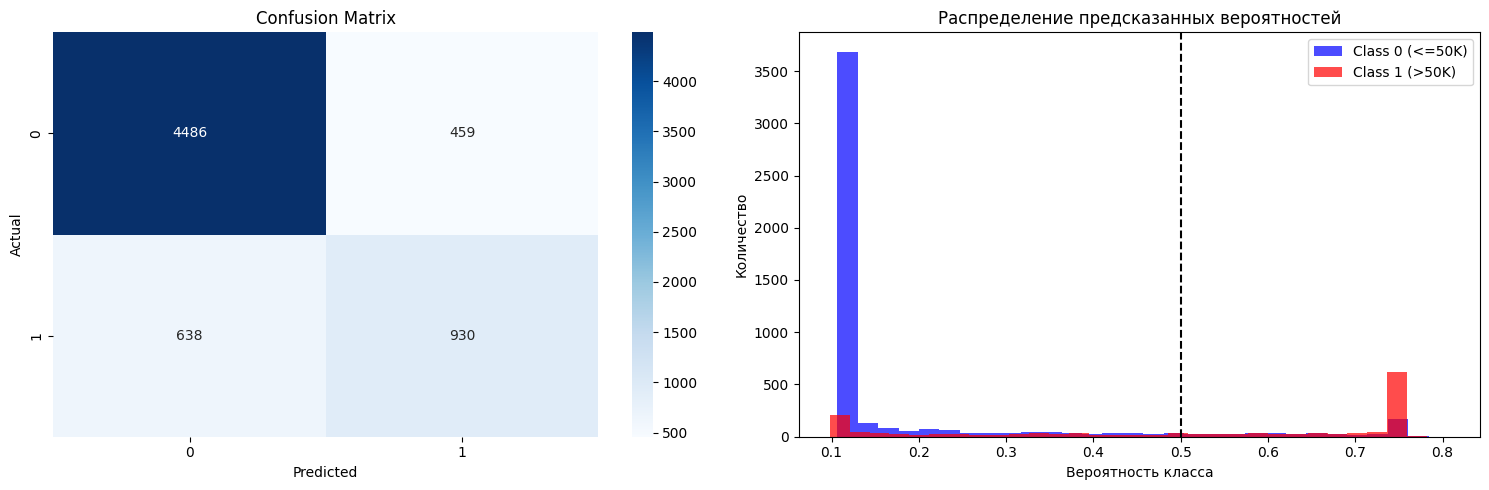

In [19]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок и распределения вероятностей
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# 1. Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Распределение предсказанных вероятностей
axes[1].hist(y_pred_proba[y_test==0], bins=30, alpha=0.7, label='Class 0 (<=50K)', color='blue')
axes[1].hist(y_pred_proba[y_test==1], bins=30, alpha=0.7, label='Class 1 (>50K)', color='red')
axes[1].set_title('Распределение предсказанных вероятностей')
axes[1].set_xlabel('Вероятность класса')
axes[1].set_ylabel('Количество')
axes[1].legend()
axes[1].axvline(x=0.5, color='black', linestyle='--')  # порог 0.5

plt.tight_layout()
plt.show()

По графику видно, что модель позвышает чужой класс. Так что значительных улучшений я не смогу достигнуть. Проблема в алгоритме, который я написал

# Улучшенный бейзлайн собственного градиентного бустинга классификации

In [20]:
my_gb_best = MyGradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5
)

my_gb_best.fit(X_train_proc, y_train)

y_pred_proba = my_gb_best.predict_proba(X_test_proc)

thresholds = np.arange(0.1, 0.91, 0.01)
best_f1 = 0
best_threshold = 0.5

for t in thresholds:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    f1_val = f1_score(y_test, y_pred_thresh)
    if f1_val > best_f1:
        best_f1 = f1_val
        best_threshold = t

# Предсказания с оптимальным порогом
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Сохраняем результаты
results_gb_clf.append({
    "Гипотеза": "Улучшенный имплементированный градиентный бустинг",
    "Accuracy": acc,
    "F1": f1,
    "ROC_AUC": roc_auc
})

# Красивый вывод
print("Результаты улучшенного бейзлайна (мой GB):\n")
print(f"Лучший порог: {best_threshold:.2f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC_AUC: {roc_auc:.4f}")

Результаты улучшенного бейзлайна (мой GB):

Лучший порог: 0.35
Accuracy: 0.8612
F1-score: 0.7308
ROC_AUC: 0.9245


In [21]:
df_results = pd.DataFrame(results_gb_clf)

# Округляем метрики для наглядности
df_results[['Accuracy', 'F1', 'ROC_AUC']] = df_results[['Accuracy', 'F1', 'ROC_AUC']].round(4)

print("="*70)
print("Сравнение всех моделей Gradient Boosting ")
print("="*70)

# Сортировка
display(df_results.sort_values("F1", ascending=False))

Сравнение всех моделей Gradient Boosting 


,Гипотеза,Accuracy,F1,ROC_AUC
4,Улучшенный бейзлайн (порог=0.37),0.8680,0.7413,0.9309
6,Улучшенный имплементированный градиентный бустинг,0.8612,0.7308,0.9245
2,Подбор гиперпараметров + баланс классов,0.8437,0.7285,0.9314
1,Сдвиг порога (порог=0.32),0.8554,0.7281,0.9238
0,Gradient Boosting базовый,0.8690,0.6963,0.9238
3,Удаление слабых признаков (<4%),0.8644,0.6883,0.9136
5,Имплементированный градиентный бустинг,0.8316,0.6290,0.8725


Ну несмотря на то что имплементированный градиентный бустинг показывает худший результат его улучшение с помощью подбора гиперпараметров и порога показало очень хороший результат. По сути данная модель уступает только улучшенному бейзлайну. Правильные подбор разлинчых параметров могут спасти даже плохой алгоритм.

# Регрессия 

## Бейзлайн градиентного бустинга регрессии

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

data = pd.read_csv("diamonds.csv")

X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

In [24]:
# Определяем категориальные и числовые признаки
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])


In [25]:
# Базовый GradientBoostingRegressor

gb_reg = Pipeline([
    ('prep', preprocessor),
    ('reg', GradientBoostingRegressor(random_state=42, n_estimators=100))
])

# Обучение
gb_reg.fit(X_train, y_train)
y_pred = gb_reg.predict(X_test)

# Метрики
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(((y_test - y_pred) ** 2).mean())

results_gb_reg = []
results_gb_reg.append({
    "Гипотеза": "GradientBoosting базовый",
    "R2": r2,
    "MAE": mae,
    "RMSE": rmse
})

In [26]:
# Вывод метрик
print("Метрики базового бейзлайна (GradientBoostingRegressor):")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Метрики базового бейзлайна (GradientBoostingRegressor):
R2: 0.9968
MAE: 136.4165
RMSE: 222.8989


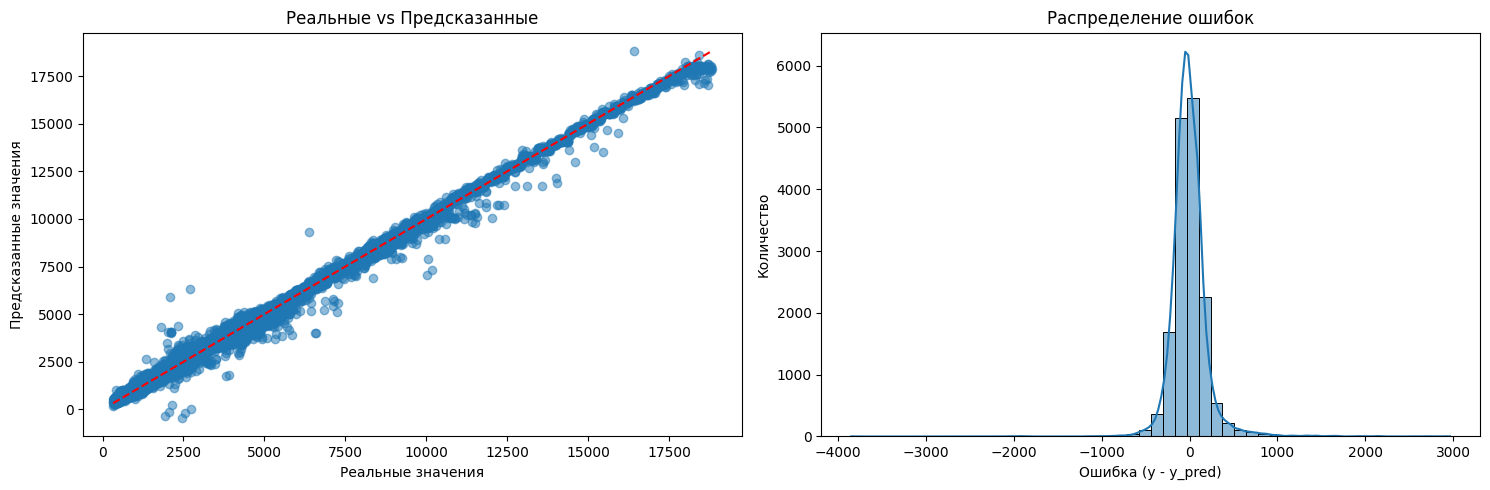

In [27]:
# Графики

fig, axes = plt.subplots(1, 2, figsize=(15,5))

# 1. Реальные vs предсказанные
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title('Реальные vs Предсказанные')
axes[0].set_xlabel('Реальные значения')
axes[0].set_ylabel('Предсказанные значения')

# 2. Распределение ошибок
errors = y_test - y_pred
sns.histplot(errors, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Распределение ошибок')
axes[1].set_xlabel('Ошибка (y - y_pred)')
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

Хорошие результаты, однако они сильно хуже чем решающие деревья и случайный лес. Но лучше чем KNN и линейная регрессия. Сейчас буду пытаться их улучшить

# Гипотезы

## Гипотеза 1: сегментация по цене

## Гипотеза 2: полимиальные признаки

## Гипотеза 3: логарифмическое преобразование целевой переменной

In [28]:
# Гипотеза 1

# Сегментация
threshold_price = 5000
mask_low = y_train <= threshold_price
mask_high = y_train > threshold_price

# Модели для каждого сегмента
gb_low = Pipeline([
    ('prep', preprocessor),
    ('reg', GradientBoostingRegressor(random_state=42, n_estimators=100))
])
gb_high = Pipeline([
    ('prep', preprocessor),
    ('reg', GradientBoostingRegressor(random_state=42, n_estimators=100))
])

# Обучаем модели
gb_low.fit(X_train[mask_low], y_train[mask_low])
gb_high.fit(X_train[mask_high], y_train[mask_high])

# Предсказания
y_pred = np.zeros_like(y_test)
mask_test_low = y_test <= threshold_price
mask_test_high = y_test > threshold_price
y_pred[mask_test_low] = gb_low.predict(X_test[mask_test_low])
y_pred[mask_test_high] = gb_high.predict(X_test[mask_test_high])

# Метрики
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(((y_test - y_pred)**2).mean())

# Сохраняем результаты
results_gb_reg.append({
    "Гипотеза": "Гипотеза 1",
    "R2": r2,
    "MAE": mae,
    "RMSE": rmse
})

In [29]:
# Гипотеза 2

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor

# Полимиальные признаки только для числовых колонок
num_transformer = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor_poly = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', num_transformer, num_features)
])

# Модель Gradient Boosting
gb_poly = Pipeline([
    ('prep', preprocessor_poly),
    ('reg', GradientBoostingRegressor(random_state=42, n_estimators=100))
])

# Обучение
gb_poly.fit(X_train, y_train)

# Предсказания
y_pred = gb_poly.predict(X_test)

# Метрики
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(((y_test - y_pred)**2).mean())

# Сохраняем результаты
results_gb_reg.append({
    "Гипотеза": "Гипотеза 2",
    "R2": r2,
    "MAE": mae,
    "RMSE": rmse
})

In [30]:
# Гипотеза 3

# Логарифмируем целевую переменную
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Модель
gb_log = Pipeline([
    ('prep', preprocessor),
    ('reg', GradientBoostingRegressor(random_state=42, n_estimators=100))
])

gb_log.fit(X_train, y_train_log)

# Предсказания и обратное преобразование
y_pred_log = gb_log.predict(X_test)
y_pred = np.expm1(y_pred_log)  # обратное log1p

# Метрики
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(((y_test - y_pred)**2).mean())

# Сохраняем результаты
results_gb_reg.append({
    "Гипотеза": "Гипотеза 3",
    "R2": r2,
    "MAE": mae,
    "RMSE": rmse
})

In [31]:
df_results = pd.DataFrame(results_gb_reg)

print("="*70)
print("Сравнение всех моделей Gradient Boosting Regressor")
print("="*70)

display(df_results.sort_values("R2", ascending=False))

Сравнение всех моделей Gradient Boosting Regressor


,Гипотеза,R2,MAE,RMSE
2,Гипотеза 2,0.996979,128.888837,217.058104
0,GradientBoosting базовый,0.996814,136.416514,222.898932
3,Гипотеза 3,0.991766,174.922286,358.344633
1,Гипотеза 1,0.825798,1018.748239,1648.285290


Что ж, интересные наблюдения. Сегментация дает ужасные результаты. Впервые. Видимо градиентный бустинг на данном датасете с ней плохо работает. Логарифмическая трансформация цены тоже не дала улучшений. Полимиальные признаки дали небольшое улучшение. Посчитаем гипотезу 2 за улучшенный бейзлайн, ибо только она дала лучший результат и не будем писать отдельный пункт. Еще раз обучать модель с гипотезой 2 смысла не вижу.

# Имплементация градиентного бустинга для регрессии

Метрики базового бейзлайна (MyGradientBoosting):
R2: 0.9999
MAE: 17.6510
RMSE: 44.4838


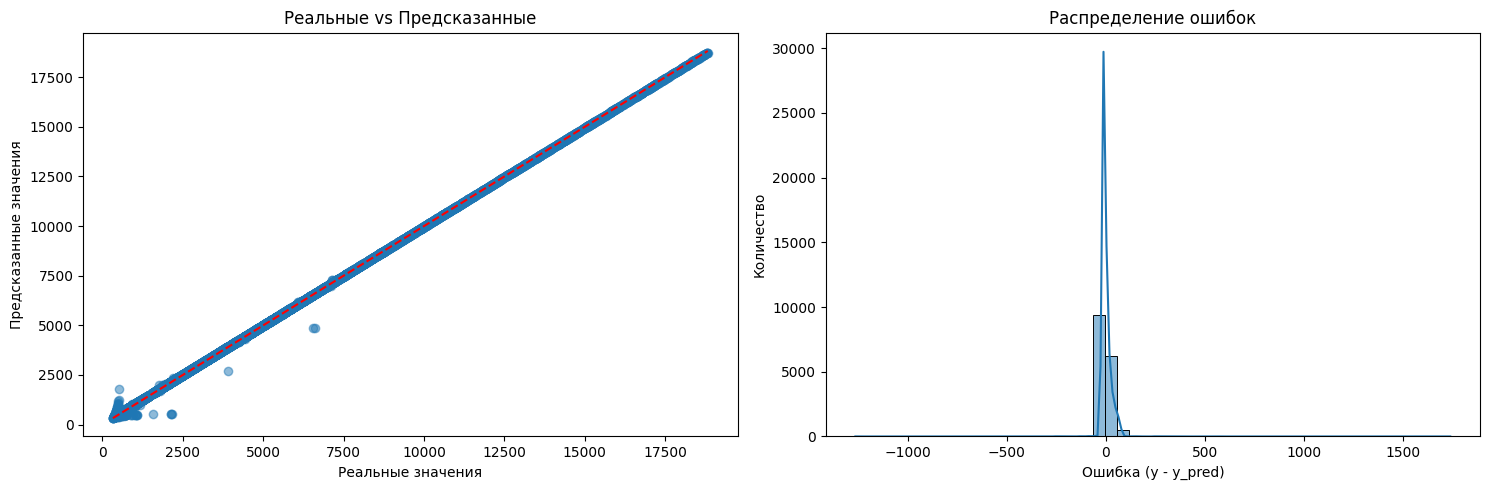

In [32]:


X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

class MyGradientBoostingRegressor:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=25):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.F0 = None
        
    def fit(self, X, y):
        # Инициализация константной модели: среднее значение целевой переменной
        self.F0 = np.mean(y)
        F_pred = np.full(y.shape, self.F0)
        self.trees = []

        for _ in range(self.n_estimators):
            # Вычисляем остатки (residuals)
            residual = y - F_pred

            # Обучаем дерево на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)
            self.trees.append(tree)

            # Обновляем предсказания
            F_pred += self.learning_rate * tree.predict(X)
    
    def predict(self, X):
        F_pred = np.full(X.shape[0], self.F0)
        for tree in self.trees:
            F_pred += self.learning_rate * tree.predict(X)
        return F_pred

# Обучение и метрики
my_gb = MyGradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=25)
my_gb.fit(X_train_proc, y_train)

y_pred = my_gb.predict(X_test_proc)

# Метрики
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(((y_test - y_pred)**2).mean())

# Сохраняем результаты
results_gb_reg.append({
    "Гипотеза": "Базовый MyGradientBoosting",
    "R2": r2,
    "MAE": mae,
    "RMSE": rmse
})

# Вывод метрик
print("Метрики базового бейзлайна (MyGradientBoosting):")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# -----------------------------
# Графики
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# 1. Реальные vs предсказанные
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title('Реальные vs Предсказанные')
axes[0].set_xlabel('Реальные значения')
axes[0].set_ylabel('Предсказанные значения')

# 2. Распределение ошибок
errors = y_test - y_pred
sns.histplot(errors, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Распределение ошибок')
axes[1].set_xlabel('Ошибка (y - y_pred)')
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

In [33]:
df_results = pd.DataFrame(results_gb_reg)

print("="*70)
print("Сравнение всех моделей Gradient Boosting Regressor")
print("="*70)

display(df_results.sort_values("R2", ascending=False))

Сравнение всех моделей Gradient Boosting Regressor


,Гипотеза,R2,MAE,RMSE
4,Базовый MyGradientBoosting,0.999873,17.650987,44.483763
2,Гипотеза 2,0.996979,128.888837,217.058104
0,GradientBoosting базовый,0.996814,136.416514,222.898932
3,Гипотеза 3,0.991766,174.922286,358.344633
1,Гипотеза 1,0.825798,1018.748239,1648.285290


Ну результаты лучше чем у обычного градиентного бустинга. Думаю ето за счет того, что я отказался от гипотезы настройки гиперпараметров, а здесь я настроил глубину побольше и он дал хороший результат. Ну теперь попробуем еще применить к ними полимиальные признаки.

# Улучшенный безлайн имплементации градиентного бустинга регрессии

Метрики для гипотезы 2 — Полимиальные признаки:
R2: 0.9995
MAE: 19.2397
RMSE: 86.4913


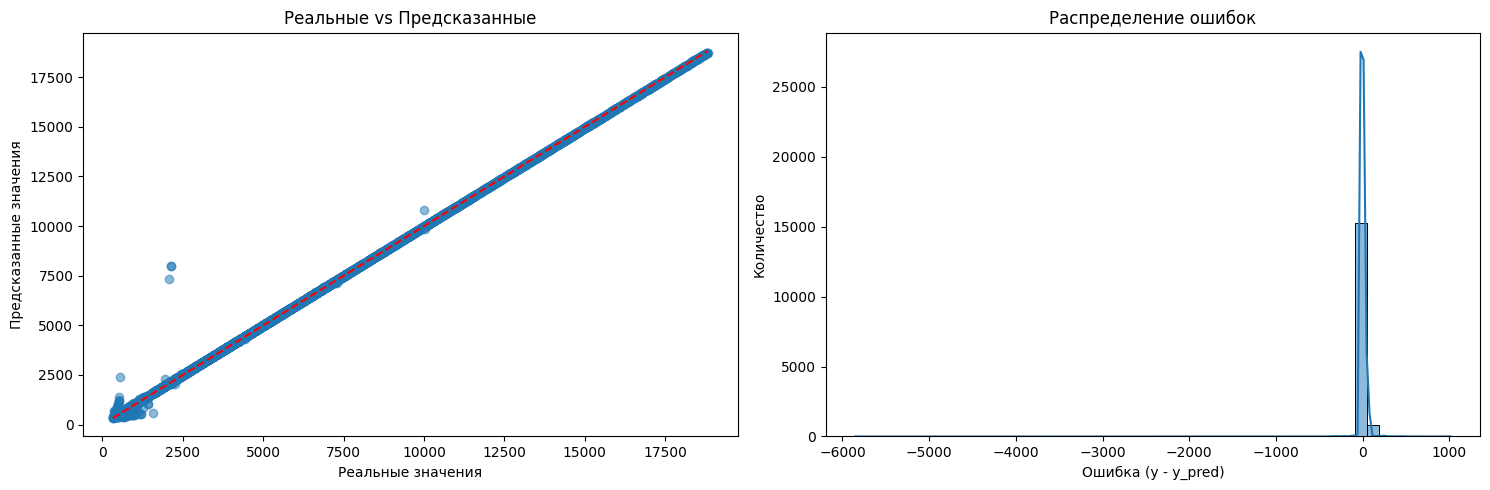

In [34]:

# Полимиальные признаки только для числовых колонок

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_num_poly = poly.fit_transform(X_train[num_features])
X_test_num_poly = poly.transform(X_test[num_features])


ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train[cat_features]).toarray()
X_test_cat = ohe.transform(X_test[cat_features]).toarray()


# Объединяем числовые и категориальные признаки

X_train_proc_poly = np.hstack([X_train_cat, X_train_num_poly])
X_test_proc_poly = np.hstack([X_test_cat, X_test_num_poly])

# Обучение 

my_gb_poly = MyGradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=25)
my_gb_poly.fit(X_train_proc_poly, y_train)

# Предсказания
y_pred = my_gb_poly.predict(X_test_proc_poly)


# Метрики
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(((y_test - y_pred)**2).mean())

# Сохраняем результаты
results_gb_reg.append({
    "Гипотеза": "Гипотеза 2 — Полимиальные признаки",
    "R2": r2,
    "MAE": mae,
    "RMSE": rmse
})

print("Метрики для гипотезы 2 — Полимиальные признаки:")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Графики

fig, axes = plt.subplots(1, 2, figsize=(15,5))

# 1. Реальные vs предсказанные
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_title('Реальные vs Предсказанные')
axes[0].set_xlabel('Реальные значения')
axes[0].set_ylabel('Предсказанные значения')

# 2. Распределение ошибок
errors = y_test - y_pred
sns.histplot(errors, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Распределение ошибок')
axes[1].set_xlabel('Ошибка (y - y_pred)')
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

In [35]:
df_results = pd.DataFrame(results_gb_reg)

print("="*70)
print("Сравнение всех моделей Gradient Boosting Regressor")
print("="*70)

display(df_results.sort_values("R2", ascending=False))

Сравнение всех моделей Gradient Boosting Regressor


,Гипотеза,R2,MAE,RMSE
4,Базовый MyGradientBoosting,0.999873,17.650987,44.483763
5,Гипотеза 2 — Полимиальные признаки,0.999520,19.239683,86.491321
2,Гипотеза 2,0.996979,128.888837,217.058104
0,GradientBoosting базовый,0.996814,136.416514,222.898932
3,Гипотеза 3,0.991766,174.922286,358.344633
1,Гипотеза 1,0.825798,1018.748239,1648.285290


Что ж, попытка улучшить мой градиентный бустинг привели лишь к его ухудшению. На графиках мы видим, что мой собственный градиентный бустинг показывает наилучшие метрики. О причинах етого я писал выше. Из базовых вариантов полимиальные признаки дали небольшое улучшение. Сегментация подвела в первый раз.

# Итоговый анализ

В задачах регрессии наилучшие результаты показали случайный лес и разрешающие деревья. Они показали почти идеально предсказания результатов и было очень похоже, что они переобучились, однако проверка на кросс-валидации показала, что переобучения не было. Сильно хуже, но тоже с хорошими результатами показал себя градиентный бустинг. KNN и линейная регрессия показали посредственные результаты, особенно линейная регрессия. Там только сегментация помогла сделать относительно хорошие результаты.

В задачах классификации модели показывали схожие результаты. Точность была всегда в районе 0.8-0.87, а f1 от 0,63 до 0,75. KNN показала наихудший результат: при неплохой точности показатели f1 оставались на минимальных по сравнению с остальными моделями значениях. Логистическая регрессия позволила приблизить f1 к 0,7 что является неплохим результатом по сравнению с KNN. Решающие деревья проявили себя чуть хуже логистической регрессии, а вот случайный лес проявил себя уже чуть лучше логистической регрессии. Он смог превысить 0.7 значнеие в f1, при етом показав точность в 0,85. Ну и лучший результат в классификации показал градиентный бустинг с результатми точности в 0,87 и f1 в 0,74, что является наилучшим результатом.